In [42]:
import numpy as np
import ast
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score
from sklearn.metrics import precision_recall_fscore_support as score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import time
import gensim
import nltk
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from sklearn.naive_bayes import MultinomialNB
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from gensim.sklearn_api.w2vmodel import W2VTransformer
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.manifold import TSNE

Load the train data into a pandas dataframe and some preliminary statistics checks:-

In [2]:
tr_labels = pd.read_csv('training_variants')
#print(tr_labels.head)

tr_txt = pd.read_csv('training_text', sep='\|\|', skiprows=1, header=None,names=["ID","Text"])
#print(tr_txt.head)

train = pd.merge(tr_txt, tr_labels, on='ID')
#print(train.head)

train.describe(include='all')

/home/aditya15007/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


,ID,Text,Gene,Variation,Class
count,3321.000000,3316,3321,3321,3321.000000
unique,NaN,1920,264,2996,NaN
top,NaN,The PTEN (phosphatase and tensin homolog) phos...,BRCA1,Truncating Mutations,NaN
freq,NaN,53,264,93,NaN
mean,1660.000000,NaN,NaN,NaN,4.365854
std,958.834449,NaN,NaN,NaN,2.309781
min,0.000000,NaN,NaN,NaN,1.000000
25%,830.000000,NaN,NaN,NaN,2.000000
50%,1660.000000,NaN,NaN,NaN,4.000000
75%,2490.000000,NaN,NaN,NaN,7.000000


In [ ]:
X = train['Text'].values
print(X.shape)

A function to pre-process text and save it to a file.

In [3]:
def preprocess(X, filename):
    # pre-processing by nltk
    t_init = time.time()

    default_stopwords = set(nltk.corpus.stopwords.words('english'))
    #will have to add the following custom 
    custom_stopwords = set(["fig", "figure", "et", "al", "table",
                        "data", "analysis", "analyze", "study",
                        "method", "result", "conclusion", "author",
                        "find", "found", "show", "perform",
                        "demonstrate", "evaluate", "discuss"])
    all_stopwords = default_stopwords | custom_stopwords
    eng_stemmer = nltk.stem.SnowballStemmer('english')

    #X_preprocessed = []
    list_all_words = []
#     list_all_strings = []
    print("Started preprocessing!")
    
    f = open(filename,'w')
    for i,x in enumerate(X):
        print("Iteration: ", i)
        #tokenization
        words = nltk.word_tokenize(x)
        #remove single character words
        words = [word for word in words if len(word) > 1]
        #removing numbers
        words = [word for word in words if not word.isnumeric()]
        #convert to lower case
        words = [word.lower() for word in words]
        #stem the words
        words = [eng_stemmer.stem(word) for word in words]
        #remove stopwords
        words = [word for word in words if word not in all_stopwords]
        #X_preprocessed.append(str(words))
        for word in words:
            list_all_words.append(word)
        f.write("%s\n" % str(words))
            
#     print("Writing to file...")

    ## I now wish to count the most frequent words and plot them

    fdist = nltk.FreqDist(list_all_words)
    fdist.plot(30,cumulative=False)

    print("Finished preprocessing!")

    t_end = time.time()
    print("Finished in ", t_end-t_init, " secs" )

A function to load the pre-processed data from the saved file.

In [4]:
def load_preprocessed(filename):
    X_pre = []
    print("Loading pre-processed data...")
    with open(filename,'r') as f:
        arr = f.readlines()
        counter = 0
        for line in arr:
            counter+=1
            #print(counter)
            x = ast.literal_eval(line.strip("\n"))
            X_pre.append(str(x))
    new_text = pd.DataFrame({'preprocessed_txt': X_pre})
    return new_text
    #print(new_text)

In [5]:
new_text = load_preprocessed('new_train.txt')
new_train = train.join(new_text)
print(new_train.head)

Loading pre-processed data...
<bound method NDFrame.head of         ID                                               Text    Gene  \
0        0  Cyclin-dependent kinases (CDKs) regulate a var...  FAM58A   
1        1   Abstract Background  Non-small cell lung canc...     CBL   
2        2   Abstract Background  Non-small cell lung canc...     CBL   
3        3  Recent evidence has demonstrated that acquired...     CBL   
4        4  Oncogenic mutations in the monomeric Casitas B...     CBL   
5        5  Oncogenic mutations in the monomeric Casitas B...     CBL   
6        6  Oncogenic mutations in the monomeric Casitas B...     CBL   
7        7  CBL is a negative regulator of activated recep...     CBL   
8        8   Abstract Juvenile myelomonocytic leukemia (JM...     CBL   
9        9   Abstract Juvenile myelomonocytic leukemia (JM...     CBL   
10      10  Oncogenic mutations in the monomeric Casitas B...     CBL   
11      11  Noonan syndrome is an autosomal dominant conge...   

In [6]:
#taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        pass
         #print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [7]:
# a general purpose function to run different models and evaluate performance

def crossval_evaluate_model(model, X, y, title_plot='Confusion matrix'):
    print("Cross validating model using 5-fold Stratified cross validation...")
    #model.fit(X,y)
    y_probas = cross_val_predict(model, X, y, cv=StratifiedKFold(random_state=42),
                               n_jobs=-1, method='predict_proba', verbose=2)
    
    classes_names = np.unique(y)
    #print(classes_names)
    y_preds_indices = np.argmax(y_probas, axis=1) #horizontally, max index in each row
    y_preds = classes_names[y_preds_indices]
    #print(np.unique(y_preds))
    
    logloss = log_loss(y,y_probas)
    acc = accuracy_score(y, y_preds)
#     prec = precision_score(y,y_preds)
#     recall = recall_score(y,y_preds)

#     prec, recall, fscore, support = score(y, y_preds)
    
    print("Log loss: ", logloss)
    print("Accuracy: ", acc)
    
#     print("Precision: ", prec)
#     print("Recall: ", recall)
#     print("F-score: ", fscore)
#     print("Support: ", support)

# The reported averages are a prevalence-weighted macro-average across classes
# (equivalent to precision_recall_fscore_support with average='weighted').

    print(classification_report(y,y_preds,target_names= [str(i) for i in classes_names]))
    
    cnf_matrix = confusion_matrix(y, y_preds)
    np.set_printoptions(precision=2)
    
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=classes_names,
                      title=title_plot)
    #plt.savefig(title_plot + ".png")
    return model

In [10]:
#Tf-idf feature extraction

vectorizer = TfidfVectorizer(strip_accents = 'ascii', analyzer = 'word', stop_words = 'english')
print("Vectorizing text using tf-idf...")
X = new_train['preprocessed_txt'].values
X_new = vectorizer.fit_transform(X)
joblib.dump(vectorizer,"tf_idf_vectorizer.pkl",compress=1)
joblib.dump(X_new, "tf_idf_vectorized_train.pkl",compress=1)
y = new_train['Class'].values

Vectorizing text using tf-idf...


In [11]:
X_new = joblib.load('tf_idf_vectorized_train.pkl')
y = new_train['Class'].values

Cross validating model using 5-fold Stratified cross validation...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s finished
/home/aditya15007/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Log loss:  2.74217844806
Accuracy:  0.292984040952
             precision    recall  f1-score   support

          1       0.05      0.01      0.01       568
          2       0.00      0.00      0.00       452
          3       0.00      0.00      0.00        89
          4       0.05      0.02      0.03       686
          5       0.38      0.06      0.11       242
          6       0.38      0.04      0.07       275
          7       0.32      0.98      0.48       953
          8       0.00      0.00      0.00        19
          9       0.00      0.00      0.00        37

avg / total       0.17      0.29      0.16      3321



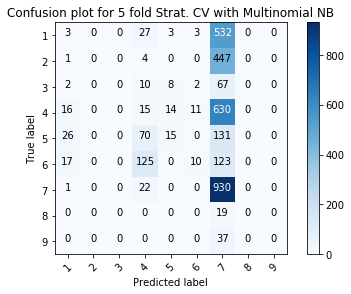

['multinomial_nb.pkl']

In [20]:
#Multinomial NB
model = MultinomialNB()
model = crossval_evaluate_model(model,X_new,y,'Confusion plot for 5 fold Strat. CV with Multinomial NB')
model.fit(X_new,y)
joblib.dump(model, "multinomial_nb.pkl",compress=1)

Cross validating model using 5-fold Stratified cross validation...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   32.8s finished
/home/aditya15007/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Log loss:  1.76259870904
Accuracy:  0.34899126769
             precision    recall  f1-score   support

          1       0.33      0.33      0.33       568
          2       0.25      0.15      0.19       452
          3       0.00      0.00      0.00        89
          4       0.21      0.09      0.13       686
          5       0.27      0.27      0.27       242
          6       0.40      0.31      0.35       275
          7       0.41      0.72      0.52       953
          8       0.00      0.00      0.00        19
          9       0.15      0.05      0.08        37

avg / total       0.30      0.35      0.31      3321



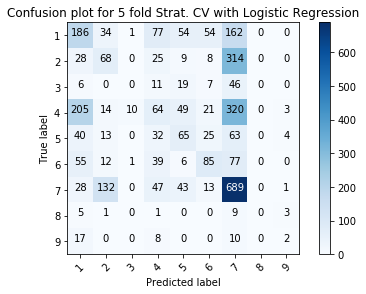

['logistic_regr.pkl']

In [21]:
#Logistic Regression
model = LogisticRegression()
model = crossval_evaluate_model(model,X_new,y,'Confusion plot for 5 fold Strat. CV with Logistic Regression')
model.fit(X_new,y)
joblib.dump(model, "logistic_regr.pkl",compress=1)

Cross validating model using 5-fold Stratified cross validation...


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  9.8min finished


Log loss:  1.95761040555
Accuracy:  0.322493224932
             precision    recall  f1-score   support

          1       0.32      0.41      0.36       568
          2       0.29      0.30      0.29       452
          3       0.00      0.00      0.00        89
          4       0.23      0.11      0.15       686
          5       0.20      0.28      0.23       242
          6       0.33      0.31      0.32       275
          7       0.42      0.49      0.45       953
          8       0.00      0.00      0.00        19
          9       0.48      0.38      0.42        37

avg / total       0.31      0.32      0.31      3321



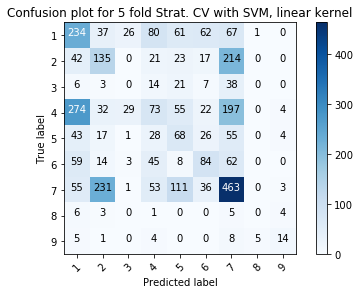

Fitting model!


['svm_linear.pkl']

In [12]:
#svc with linear kernel
model = svm.SVC(C = 0.3, kernel = 'linear', probability = True)
model = crossval_evaluate_model(model,X_new,y,'Confusion plot for 5 fold Strat. CV with SVM, linear kernel')
print("Fitting model!")
model.fit(X_new,y)
joblib.dump(model, "svm_linear.pkl",compress=1)

Cross validating model using 5-fold Stratified cross validation...


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 12.1min finished
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Log loss:  2.61169796073
Accuracy:  0.227642276423
             precision    recall  f1-score   support

          1       0.22      0.82      0.34       568
          2       0.24      0.41      0.30       452
          3       0.00      0.00      0.00        89
          4       0.00      0.00      0.00       686
          5       0.29      0.33      0.31       242
          6       0.26      0.04      0.06       275
          7       0.26      0.01      0.03       953
          8       0.00      0.00      0.00        19
          9       0.15      0.05      0.08        37

avg / total       0.19      0.23      0.14      3321



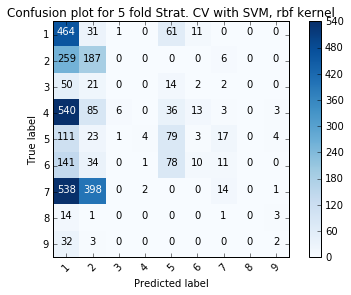

['svm_rbf.pkl']

In [76]:
#svc with rbf kernel
model = svm.SVC(C = 0.3, kernel = 'rbf', probability = True)
model = crossval_evaluate_model(model,X_new,y,'Confusion plot for 5 fold Strat. CV with SVM, rbf kernel')
model.fit(X_new,y)
joblib.dump(model, "svm_rbf.pkl",compress=1)

Cross validating model using 5-fold Stratified cross validation...


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 32.0min finished


Log loss:  1.72326575758
Accuracy:  0.396567299006
             precision    recall  f1-score   support

          1       0.30      0.20      0.24       568
          2       0.20      0.03      0.05       452
          3       0.00      0.00      0.00        89
          4       0.38      0.28      0.33       686
          5       0.30      0.24      0.27       242
          6       0.43      0.26      0.32       275
          7       0.43      0.91      0.59       953
          8       0.00      0.00      0.00        19
          9       0.00      0.00      0.00        37

avg / total       0.34      0.40      0.33      3321



/home/aditya15007/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


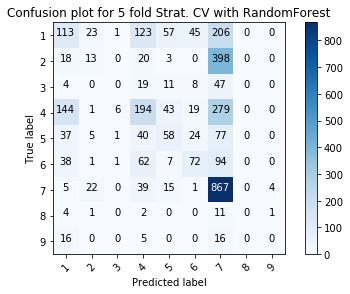

['rand_for.pkl']

In [13]:
model = RandomForestClassifier(n_estimators=1000, max_depth=15)
model = crossval_evaluate_model(model,X_new,y,'Confusion plot for 5 fold Strat. CV with RandomForest')
model.fit(X_new,y)
joblib.dump(model, "rand_for.pkl",compress=1)

Finished transforming data in  172.34492421150208  secs
Cross validating model using 5-fold Stratified cross validation...


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.4s finished


Log loss:  2.42271174732
Accuracy:  0.314965371876
             precision    recall  f1-score   support

          1       0.25      0.29      0.27       568
          2       0.27      0.30      0.28       452
          3       0.17      0.12      0.14        89
          4       0.25      0.17      0.20       686
          5       0.22      0.25      0.23       242
          6       0.31      0.29      0.30       275
          7       0.46      0.50      0.48       953
          8       0.00      0.00      0.00        19
          9       0.02      0.03      0.02        37

avg / total       0.31      0.31      0.31      3321



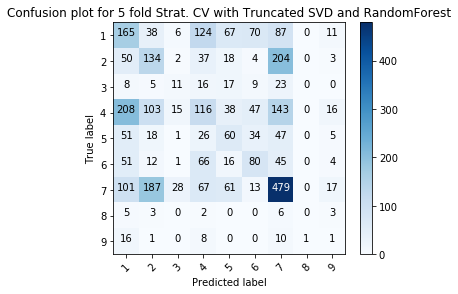

['rand_for_trunc_tfidf.pkl']

In [14]:
t_init = time.time()

trunc = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
X_trunc_tfidf = trunc.fit_transform(X_new)

t_end = time.time()
print("Finished transforming data in ", t_end-t_init, " secs" )
joblib.dump(trunc, "tfidf_trunc.pkl",compress=1)
joblib.dump(X_trunc_tfidf, "tfidf_trunc_train.pkl", compress=1)
model = RandomForestClassifier(n_estimators=1000, max_depth=15)
model = crossval_evaluate_model(model,X_trunc_tfidf,y,'Confusion plot for 5 fold Strat. CV with Truncated SVD and RandomForest')
model.fit(X_trunc_tfidf,y)
joblib.dump(model, "rand_for_trunc_tfidf.pkl",compress=1)

In [18]:
sentences = [ast.literal_eval(z) for z in new_train['preprocessed_txt']]
#print(sentences)

In [12]:
word2vec = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)
print('Finished training model, now saving...')
word2vec.save('w2v.model')

Finished training model, now saving...


In [16]:
w2v = gensim.models.Word2Vec.load('w2v.model')
w2v_new = dict(zip(w2v.wv.index2word, w2v.wv.syn0))
#print(w2v_new)
print(len(w2v_new))
#w2v_new is a word -> vector dictionary

82605


This is a a sklearn-compatible transformer class that is initialised with a word -> vector dictionary.
We already have a dictionary mapping of word -> 100-dimensional vector in the previous step. Now we use it to build features by averaging word vectors for all words in a text.

In [15]:
#reference: http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/

class MeanW2VecVectorizer(object):
    def __init__(self, w2v):
        self.w2v = w2v
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(w2v)
        
    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [19]:
joblib.dump(sentences,'sentences_train.pkl',compress=True)
meanW2V_vec = MeanW2VecVectorizer(w2v_new)
meanW2V = meanW2V_vec.fit_transform(sentences)
joblib.dump(meanW2V_vec,'meanw2v_train.pkl', compress=True)
joblib.dump(meanW2V,'meanw2v_train_X.pkl', compress=True)

['meanw2v_train_X.pkl']

In [31]:
print(meanW2V.shape)

(3321, 100)


Cross validating model using 5-fold Stratified cross validation...


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s finished


Log loss:  1.65313998161
Accuracy:  0.417946401686
             precision    recall  f1-score   support

          1       0.38      0.38      0.38       568
          2       0.30      0.24      0.26       452
          3       0.00      0.00      0.00        89
          4       0.49      0.39      0.43       686
          5       0.26      0.29      0.27       242
          6       0.47      0.37      0.42       275
          7       0.48      0.65      0.55       953
          8       0.00      0.00      0.00        19
          9       0.43      0.24      0.31        37

avg / total       0.41      0.42      0.41      3321



/home/aditya15007/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


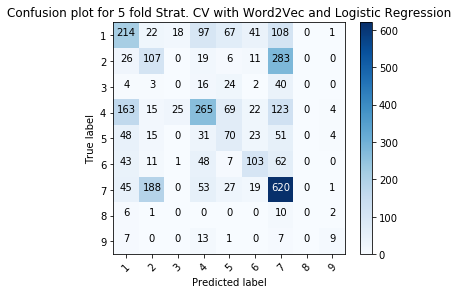

['logistic_w2v.pkl']

In [20]:
#word2vec and LogisticRegression

model = LogisticRegression()
model = crossval_evaluate_model(model,meanW2V,new_train['Class'].values,'Confusion plot for 5 fold Strat. CV with Word2Vec and Logistic Regression')
model.fit(meanW2V,new_train['Class'].values)
joblib.dump(model, "logistic_w2v.pkl",compress=1)

Cross validating model using 5-fold Stratified cross validation...


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   31.5s finished


Log loss:  2.02685740982
Accuracy:  0.432399879554
             precision    recall  f1-score   support

          1       0.33      0.33      0.33       568
          2       0.39      0.28      0.32       452
          3       0.26      0.12      0.17        89
          4       0.47      0.41      0.44       686
          5       0.29      0.26      0.28       242
          6       0.42      0.31      0.35       275
          7       0.50      0.71      0.59       953
          8       0.00      0.00      0.00        19
          9       0.22      0.11      0.15        37

avg / total       0.42      0.43      0.42      3321



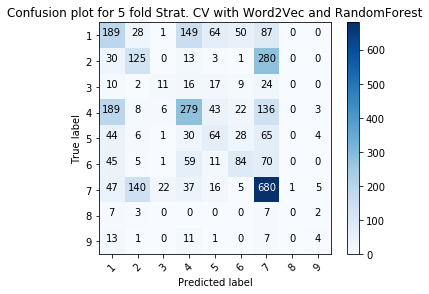

['rand_for_w2v.pkl']

In [21]:
#word2vec and RandomForest
model = RandomForestClassifier(n_estimators=1000, max_depth=15)
model = crossval_evaluate_model(model,meanW2V,new_train['Class'].values,'Confusion plot for 5 fold Strat. CV with Word2Vec and RandomForest')
model.fit(meanW2V,new_train['Class'].values)
joblib.dump(model, "rand_for_w2v.pkl",compress=1)

Cross validating model using 5-fold Stratified cross validation...


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.8s finished


Log loss:  1.58455459641
Accuracy:  0.426678711232
             precision    recall  f1-score   support

          1       0.39      0.41      0.40       568
          2       0.29      0.18      0.22       452
          3       0.00      0.00      0.00        89
          4       0.50      0.38      0.43       686
          5       0.27      0.29      0.28       242
          6       0.44      0.38      0.41       275
          7       0.49      0.69      0.57       953
          8       0.00      0.00      0.00        19
          9       0.45      0.27      0.34        37

avg / total       0.41      0.43      0.41      3321



/home/aditya15007/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


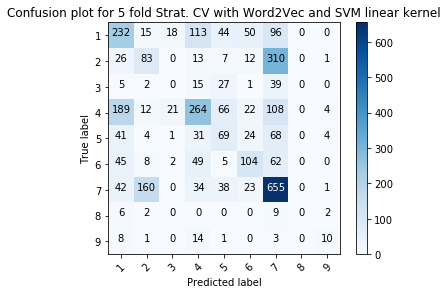

['svm_linear_w2v.pkl']

In [22]:
#word2vec and svm
model =  svm.SVC(C = 0.3, kernel = 'linear', probability = True)
model = crossval_evaluate_model(model,meanW2V,new_train['Class'].values,'Confusion plot for 5 fold Strat. CV with Word2Vec and SVM linear kernel')
model.fit(meanW2V,new_train['Class'].values)
joblib.dump(model, "svm_linear_w2v.pkl",compress=1)

In [26]:
tst_labels = pd.read_csv('test_variants.csv')
#print(tr_labels.head)

tst_txt = pd.read_csv('test_text.csv', sep='\|\|', skiprows=1, header=None,names=["ID","Text"])
#print(tr_txt.head)

test = pd.merge(tst_txt, tst_labels, on='ID')
#print(train.head)

test.describe(include='all')

/home/aditya15007/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


,ID,Text,Gene,Variation
count,986.000000,986,986,986
unique,NaN,874,279,945
top,NaN,Among the best-studied therapeutic targets in ...,TP53,Truncating Mutations
freq,NaN,24,40,18
mean,493.500000,NaN,NaN,NaN
std,284.777984,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN
25%,247.250000,NaN,NaN,NaN
50%,493.500000,NaN,NaN,NaN
75%,739.750000,NaN,NaN,NaN


(986,)
Started preprocessing!
Iteration:  0
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10
Iteration:  11
Iteration:  12
Iteration:  13
Iteration:  14
Iteration:  15
Iteration:  16
Iteration:  17
Iteration:  18
Iteration:  19
Iteration:  20
Iteration:  21
Iteration:  22
Iteration:  23
Iteration:  24
Iteration:  25
Iteration:  26
Iteration:  27
Iteration:  28
Iteration:  29
Iteration:  30
Iteration:  31
Iteration:  32
Iteration:  33
Iteration:  34
Iteration:  35
Iteration:  36
Iteration:  37
Iteration:  38
Iteration:  39
Iteration:  40
Iteration:  41
Iteration:  42
Iteration:  43
Iteration:  44
Iteration:  45
Iteration:  46
Iteration:  47
Iteration:  48
Iteration:  49
Iteration:  50
Iteration:  51
Iteration:  52
Iteration:  53
Iteration:  54
Iteration:  55
Iteration:  56
Iteration:  57
Iteration:  58
Iteration:  59
Iteration:  60
Iteration:  61
Iteration:  62
Iteration:  63
Iteration:  64
Itera

Iteration:  518
Iteration:  519
Iteration:  520
Iteration:  521
Iteration:  522
Iteration:  523
Iteration:  524
Iteration:  525
Iteration:  526
Iteration:  527
Iteration:  528
Iteration:  529
Iteration:  530
Iteration:  531
Iteration:  532
Iteration:  533
Iteration:  534
Iteration:  535
Iteration:  536
Iteration:  537
Iteration:  538
Iteration:  539
Iteration:  540
Iteration:  541
Iteration:  542
Iteration:  543
Iteration:  544
Iteration:  545
Iteration:  546
Iteration:  547
Iteration:  548
Iteration:  549
Iteration:  550
Iteration:  551
Iteration:  552
Iteration:  553
Iteration:  554
Iteration:  555
Iteration:  556
Iteration:  557
Iteration:  558
Iteration:  559
Iteration:  560
Iteration:  561
Iteration:  562
Iteration:  563
Iteration:  564
Iteration:  565
Iteration:  566
Iteration:  567
Iteration:  568
Iteration:  569
Iteration:  570
Iteration:  571
Iteration:  572
Iteration:  573
Iteration:  574
Iteration:  575
Iteration:  576
Iteration:  577
Iteration:  578
Iteration:  579
Iteratio

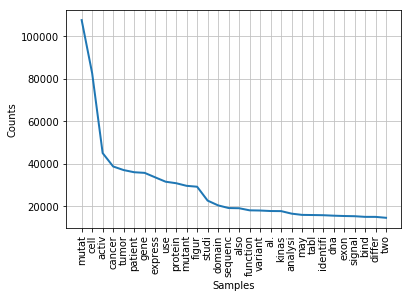

Finished preprocessing!
Finished in  460.5988869667053  secs


In [9]:
X_test = test['Text'].values
print(X_test.shape)
preprocess(X_test, 'new_test.txt')

In [27]:
new_test_pre = load_preprocessed('new_test.txt')
new_test = test.join(new_test_pre)
print(new_test.head)

Loading pre-processed data...
<bound method NDFrame.head of       ID                                               Text      Gene  \
0      1  The incidence of breast cancer is increasing i...     CHEK2   
1      2  An unselected series of 310 colorectal carcino...     AXIN2   
2      3  Mycosis fungoides and Sézary syndrome are prim...      WNT4   
3      4   Regulated progression through the cell cycle ...    SUCLA2   
4      5  Pilocytic astrocytoma (PA) is emerging as a tu...      BRAF   
5      6  The nuclei that laboratories solution p53 KIT ...     CHEK2   
6      7  Myeloid differentiation 88 (MyD88) is the key ...     CHST3   
7      8  Human ESCCs 2 occur frequently worldwide (1) ....      RNF6   
8      9  large were of activity growth this product tol...     SPAST   
9     10  The protein kinase v-akt murine thymoma viral ...      AKT1   
10    11  Endometrial carcinoma is the most common gynec...     SCN4A   
11    12  Gastrointestinal stromal tumors (GIST) are cha...     

In [28]:
sentences_test = [ast.literal_eval(z) for z in new_test['preprocessed_txt']]
joblib.dump(sentences_test,'sentences_test.pkl',compress=True)
#print(sentences)

['sentences_test.pkl']

In [19]:
#new model with w2v trained over both train and test data since it is an unsupervised algo
word2vec_2 = gensim.models.Word2Vec(sentences+sentences_test, size=100, window=5, min_count=5, workers=20)
print('Finished training model, now saving...')
word2vec_2.save('w2v_trainplustest.model')

Finished training model, now saving...


In [29]:
w2v_trtest = gensim.models.Word2Vec.load('w2v_trainplustest.model')
w2v_trtest_new = dict(zip(w2v_trtest.wv.index2word, w2v_trtest.wv.syn0))
#print(w2v_new)
print(len(w2v_trtest_new))
meanW2V_vec_trtest = MeanW2VecVectorizer(w2v_trtest_new)
meanW2V2_trtest = meanW2V_vec_trtest.fit_transform(sentences)
joblib.dump(meanW2V_vec_trtest,"w2v_trtest.pkl", compress=1)
joblib.dump(meanW2V2_trtest, "w2v_trtest_X_train.pkl",compress=1)

99173


['w2v_trtest_X_train.pkl']

In [30]:
print(meanW2V2_trtest.shape)

(3321, 100)


Cross validating model using 5-fold Stratified cross validation...


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.2s finished


Log loss:  1.66819606622
Accuracy:  0.407106293285
             precision    recall  f1-score   support

          1       0.37      0.41      0.39       568
          2       0.29      0.22      0.25       452
          3       0.00      0.00      0.00        89
          4       0.44      0.35      0.39       686
          5       0.26      0.28      0.27       242
          6       0.43      0.36      0.39       275
          7       0.48      0.63      0.55       953
          8       0.00      0.00      0.00        19
          9       0.48      0.35      0.41        37

avg / total       0.39      0.41      0.39      3321



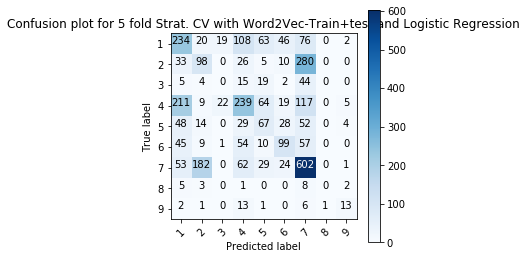

['logistic_w2v_trtest.pkl']

In [32]:
#word2vec and LogisticRegression
model = LogisticRegression()
model = crossval_evaluate_model(model,meanW2V2_trtest,new_train['Class'].values,'Confusion plot for 5 fold Strat. CV with Word2Vec-Train+test and Logistic Regression')
model.fit(meanW2V2_trtest,new_train['Class'].values)
joblib.dump(model, "logistic_w2v_trtest.pkl",compress=1)

Cross validating model using 5-fold Stratified cross validation...


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   29.6s finished


Log loss:  1.97700589683
Accuracy:  0.426377597109
             precision    recall  f1-score   support

          1       0.33      0.30      0.32       568
          2       0.32      0.23      0.26       452
          3       0.25      0.12      0.17        89
          4       0.48      0.45      0.47       686
          5       0.30      0.26      0.28       242
          6       0.41      0.31      0.35       275
          7       0.49      0.70      0.58       953
          8       0.00      0.00      0.00        19
          9       0.22      0.11      0.15        37

avg / total       0.41      0.43      0.41      3321



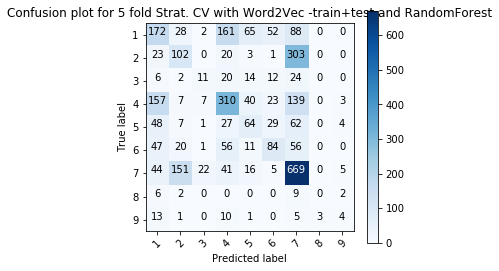

['rand_for_w2v_trtest.pkl']

In [33]:
#word2vec and RandomForest
model = RandomForestClassifier(n_estimators=1000, max_depth=15)
model = crossval_evaluate_model(model,meanW2V2_trtest,new_train['Class'].values,'Confusion plot for 5 fold Strat. CV with Word2Vec -train+test and RandomForest')
model.fit(meanW2V2_trtest,new_train['Class'].values)
joblib.dump(model, "rand_for_w2v_trtest.pkl",compress=1)

Cross validating model using 5-fold Stratified cross validation...


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished


Log loss:  1.6045817989
Accuracy:  0.398675097862
             precision    recall  f1-score   support

          1       0.31      0.32      0.31       568
          2       0.29      0.20      0.24       452
          3       0.00      0.00      0.00        89
          4       0.42      0.32      0.36       686
          5       0.29      0.25      0.27       242
          6       0.33      0.32      0.32       275
          7       0.49      0.71      0.58       953
          8       0.00      0.00      0.00        19
          9       0.36      0.32      0.34        37

avg / total       0.37      0.40      0.38      3321



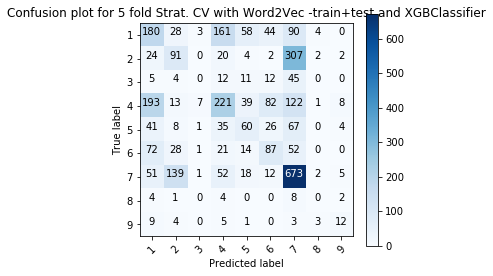

['xgb_w2v_trtest.pkl']

In [35]:
model = XGBClassifier(max_depth=4,objective='multi:softprob',learning_rate=0.03333)
model = crossval_evaluate_model(model,meanW2V2_trtest,new_train['Class'].values,'Confusion plot for 5 fold Strat. CV with Word2Vec -train+test and XGBClassifier')
model.fit(meanW2V2_trtest,new_train['Class'].values)
joblib.dump(model, "xgb_w2v_trtest.pkl",compress=1)

Cross validating model using 5-fold Stratified cross validation...


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   51.5s finished


Log loss:  1.96729029737
Accuracy:  0.312556458898
             precision    recall  f1-score   support

          1       0.26      0.21      0.23       568
          2       0.29      0.18      0.22       452
          3       0.04      0.06      0.05        89
          4       0.37      0.35      0.36       686
          5       0.13      0.23      0.17       242
          6       0.16      0.16      0.16       275
          7       0.47      0.52      0.49       953
          8       0.00      0.00      0.00        19
          9       0.02      0.03      0.03        37

avg / total       0.32      0.31      0.31      3321



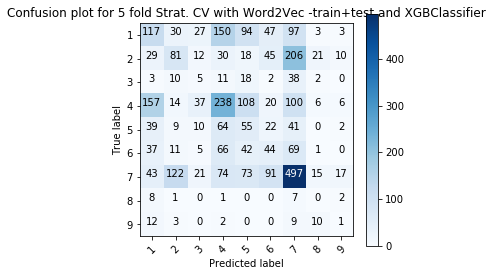

['ada_w2v_trtest.pkl']

In [37]:
model = AdaBoostClassifier(n_estimators=1000,learning_rate=0.1)
model = crossval_evaluate_model(model,meanW2V2_trtest,new_train['Class'].values,'Confusion plot for 5 fold Strat. CV with Word2Vec -train+test and XGBClassifier')
model.fit(meanW2V2_trtest,new_train['Class'].values)
joblib.dump(model, "ada_w2v_trtest.pkl",compress=1)

Cross validating model using 5-fold Stratified cross validation...


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.9min finished


Log loss:  2.91272899578
Accuracy:  0.390243902439
             precision    recall  f1-score   support

          1       0.34      0.36      0.35       568
          2       0.26      0.25      0.25       452
          3       0.11      0.12      0.12        89
          4       0.45      0.35      0.40       686
          5       0.30      0.29      0.30       242
          6       0.38      0.32      0.35       275
          7       0.48      0.58      0.53       953
          8       0.08      0.05      0.06        19
          9       0.33      0.32      0.33        37

avg / total       0.39      0.39      0.39      3321



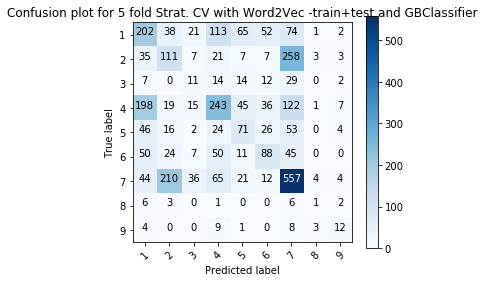

['gbc_w2v_trtest.pkl']

In [39]:
model = GradientBoostingClassifier(n_estimators=1000,learning_rate=0.1)
model = crossval_evaluate_model(model,meanW2V2_trtest,new_train['Class'].values,'Confusion plot for 5 fold Strat. CV with Word2Vec -train+test and GBClassifier')
model.fit(meanW2V2_trtest,new_train['Class'].values)
joblib.dump(model, "gbc_w2v_trtest.pkl",compress=1)

In [43]:
def plot_data(X,Y):
    model = TSNE(n_components=2,verbose=2 ,random_state=1)
    X_tf=model.fit_transform(X)
    # print X_tf.shape
    plt.figure(figsize=(10, 5))
    names = set(Y)
    # print names
    X1=X_tf[:,0]
    X2=X_tf[:,1]
    for name in names:
        tx1=[]
        tx2=[]
        for i in range(len(X_tf)):
            # print i
            if Y[i]==name:
                tx1.append(X1[i])
                tx2.append(X2[i])
        plt.plot(tx1, tx2, linestyle='none', marker='o', label=name)
    plt.legend(numpoints=1)
    plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3321 samples in 0.084s...
[t-SNE] Computed neighbors for 3321 samples in 2.760s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3321
[t-SNE] Computed conditional probabilities for sample 2000 / 3321
[t-SNE] Computed conditional probabilities for sample 3000 / 3321
[t-SNE] Computed conditional probabilities for sample 3321 / 3321
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.419s
[t-SNE] Iteration 50: error = 81.3036499, gradient norm = 0.0411121 (50 iterations in 8.709s)
[t-SNE] Iteration 100: error = 75.5514450, gradient norm = 0.0026918 (50 iterations in 6.960s)
[t-SNE] Iteration 150: error = 75.3797455, gradient norm = 0.0025351 (50 iterations in 6.605s)
[t-SNE] Iteration 200: error = 75.3673782, gradient norm = 0.0006865 (50 iterations in 7.258s)
[t-SNE] Iteration 250: error = 75.3609161, gradient norm = 0.0004289 (50 iterations in 6.296s)
[t-SNE] KL divergence after 250 iterati

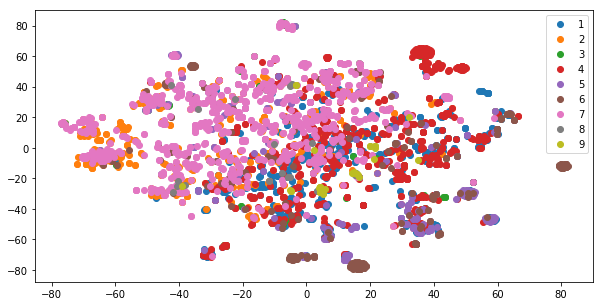

In [44]:
plot_data(meanW2V2_trtest,new_train['Class'].values)